## ELIXIR Spatial Transcriptomics Course
### Practical 1b: Segmentation free cell identification using `sainsc`
Date: 2025-01-22

Author(s): Niklas Müller-Bötticher, Rasool Saghaleyni

Author(s) email: niklas.mueller-boetticher@bih-charite.de, rasool.saghaleyni@scilifelab.

⚠️ Note: The proper environment for this notebook is `p1_segmentation_sainsc`. It can be activated by selecting the kernel in the Jupyter notebook.

## Imports

First we are going to load all necessary packages for the analysis. 

We will use `sainsc` for the main analysis and `scanpy` to cluster the cell-types in 
our unsupervised analysis.

In [9]:
# Don't try this at home!
# Usually you do want to notice if warnings come up!
import warnings

from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=TqdmWarning)

In [10]:
from pathlib import Path

import pandas as pd
import scanpy as sc
import spatialdata as sd

# load and prepare data
import polars as pl
from sainsc import LazyKDE

from sainsc.io import read_Xenium
from sainsc.utils import celltype_signatures

First we define the paths to our directory where we keep the Xenium sample that we want 
to analyze.

In [11]:
import sys
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook

from _paths import PROJECT_DIR, RESULTS_DIR, xenium_path_cropped
compressed_transcript_csv = Path(RESULTS_DIR, 'sainsc', 'trans.csv.gz')

## Load and prepare data for sainsc

Input/Start: `SpatialData` object

Output: `sainsc.LazyKDE`

In [39]:
sdata = sd.read_zarr(xenium_path_cropped)
sdata

/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_

SpatialData object, with associated Zarr store: /ictstr01/groups/ml01/datasets/projects/2025_sergio_troutpy/example_datasets/mousebrain_prime_crop_communication.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 5000), (5, 1500, 2500), (5, 750, 1250), (5, 375, 625), (5, 188, 312)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
│     └── 'nucleus_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 17) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (1762, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (1722, 2) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (1738, 1) (2D shapes)
│     ├── 'image_patches': GeoDataFrame shape: (6, 3) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (1750, 1) (2D shapes)
└── Tables
      ├── 'segmentat

In [13]:
transcripts = sdata.points["transcripts"][["feature_name", "x", "y", "codeword_category"]].compute()
transcripts = transcripts.reset_index(drop=True)

Need to rename the transcript columns to a valid valid columns: ["", "gene", "x", "y", "codeword_category"]

In [14]:
transcripts = transcripts.rename({"feature_name": "gene", "x": "x", "y": "y"})
transcripts = transcripts[transcripts["codeword_category"] == "predesigned_gene"]

In [15]:
transcripts.columns = ["gene", "x", "y", "codeword_category"]

In [16]:
transcripts

,gene,x,y,codeword_category
0,Apc,5747.343750,2547.484375,predesigned_gene
1,Ina,6014.375000,1975.656250,predesigned_gene
2,Ina,6015.000000,1976.921875,predesigned_gene
3,Ina,6015.750000,1992.171875,predesigned_gene
4,Ina,6111.593750,1926.812500,predesigned_gene
...,...,...,...,...
5132691,Snrpn,5231.984375,2501.890625,predesigned_gene
5132692,Snrpn,5235.671875,2509.812500,predesigned_gene
5132693,Ina,6037.062500,1968.343750,predesigned_gene
5132694,Ina,6042.281250,1949.781250,predesigned_gene


In [17]:
transcripts.to_csv(compressed_transcript_csv, compression="gzip")

In [18]:
n_threads = 16

In [19]:
# Read xenium file, rename columns and filter blanks/controls
transcripts = pl.read_csv(
    compressed_transcript_csv,
    columns=["gene", "x", "y"],
    schema_overrides={"gene": pl.Categorical},
    n_threads=n_threads,
).filter(~pl.col("gene").cast(pl.Utf8).str.contains("(BLANK|NegControl)"))

In [20]:
brain = LazyKDE.from_dataframe(transcripts, resolution=1000, binsize=3, n_threads=n_threads)

In [23]:
brain

LazyKDE (16 threads)
    genes: 5005
    shape: (355, 213)
    resolution: 3000.0 nm / px

Before we start it is good to get a brief overview of the two main Classes in `sainsc`.

1. [`GridCounts`](https://sainsc.readthedocs.io/page/autoapi/sainsc/GridCounts.html):
This class holds the data as a dictionary of sparse matrices of the same 
shape. You rarely will need to interact with it directly unless you want to, filter the
genes or crop/mask the sample. It mostly behaves like a Python dictionary but is implemented
in Rust. Therefore, iterating over the count matrices of each gene might be slow as the 
data needs to be transformed every time.
2. [`LazyKDE`](https://sainsc.readthedocs.io/page/autoapi/sainsc/LazyKDE.html): This is the class that you mostly will interact with. It contains a `GridCounts`
instance in its `counts` attribute and otherwise exposes almost all methods necessary to
perform the analysis.

We will use the *transcripts.csv.gz* (or *transcripts.parquet*) to load the locations of
all identified transcripts. The control probes from the Xenium study will be automatically 
filtered out.

We can furthermore specify the size of the bins we will asign the transcripts into (by 
default this is set to 0.5 um) and the number of threads we want to use to process the data.

There are options to directly load data from common file formats/technologies
such as Stereo-seq, Xenium, and Vizgen. If none of the options fit for your use case 
you can have a look at [`LazyKDE.from_dataframe`](https://sainsc.rtd.io/api/) 
or [`GridCounts.from_dataframe`](https://sainsc.rtd.io/api) methods.

In [25]:
# TODO: Why does this not load? 
# brain = read_Xenium(compressed_transcript_csv, n_threads=8)
# brain

The `LazyKDE` object will give us some useful information when we print it; including
the number of genes, the size of the sample in pixels and the resolution.

Next we can get a quick overview of our sample by calculating the total mRNA and plotting
it. If we can squint our eyes, we can notice some technical artifacts; the mRNA seems to
be lower at certain locations that seem to form a grid, likely along the stitching borders.

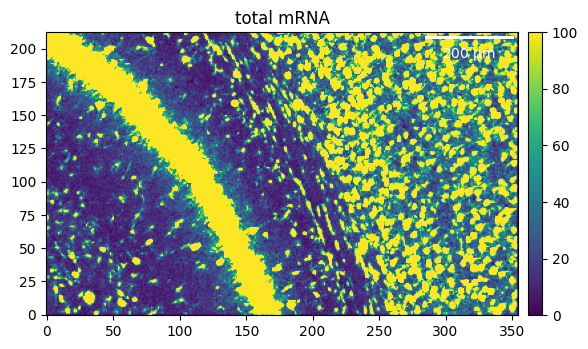

In [26]:
brain.calculate_total_mRNA()
_ = brain.plot_genecount(im_kwargs={"vmax": 100})

We can crop our sample to remove some "dead" space to further speed up processing or to
"zoom" into a smaller region of interest (ROI).

Alternatively, we could also use the 
[`GridCounts.filter_mask`](https://sainsc.readthedocs.io/page/autoapi/sainsc/GridCounts.filter_mask.html)
method to use an arbitrary binary mask to determine the ROI. All the transcripts outside 
our ROI will then be dropped. This allows us to filter the ROI to any shape desired.

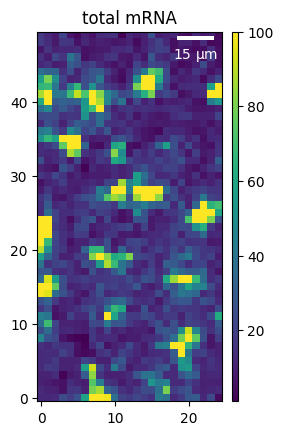

In [90]:
# select region of interest
brain.counts.crop((0, 25), (50, 100))

brain.calculate_total_mRNA()
_ = brain.plot_genecount(im_kwargs={"vmax": 100})

It is always a good idea to also check the distribution of transcripts detected per gene.

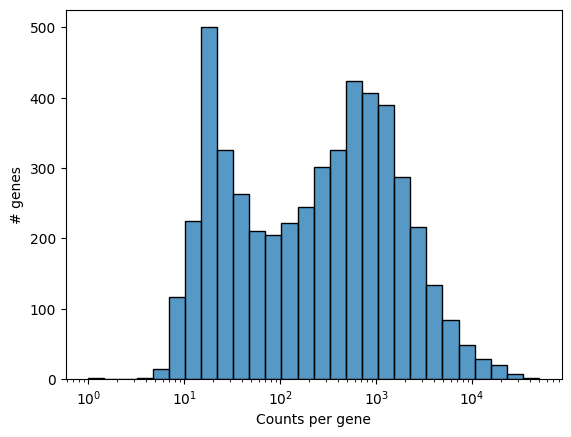

In [27]:
_ = brain.plot_genecount_histogram()

The kernel defines on how we will smooth the gene expression. The go-to choice is to use
a gaussian kernel, however any square `numpy.ndarray` can be used.

The size of the kernel can either be defined in pixels or in µm (if the resolution is set). 

The required kernel size may depend on the technology. Here, we will use 2.5 µm.

In [28]:
brain.gaussian_kernel(2.5, unit="um")

Now we can first smooth the total mRNA and visualize it.

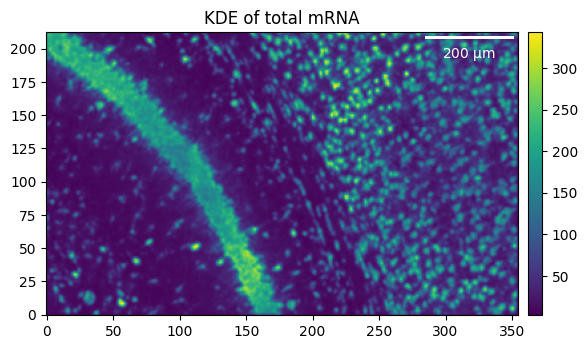

In [29]:
brain.calculate_total_mRNA_KDE()
_ = brain.plot_KDE()

The distribution of the smoothed gene expression can be used to determine a threshold to
use for filtering out background noise. 

Good first choice = 200?

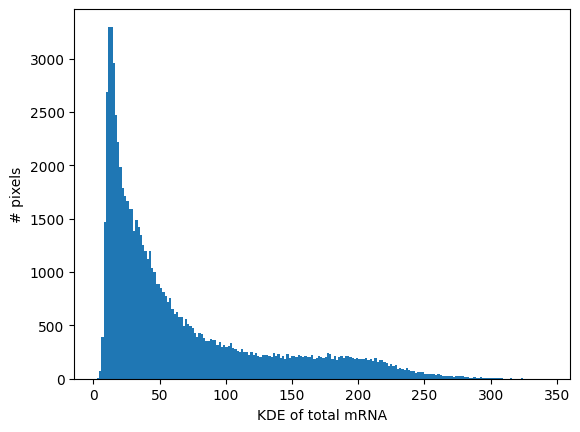

In [30]:
_ = brain.plot_KDE_histogram(bins=200)

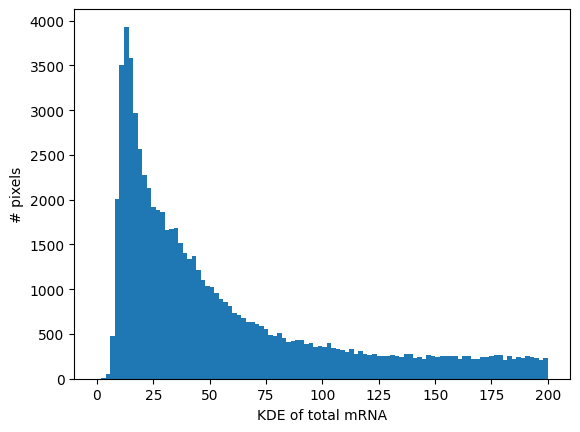

In [31]:
_ = brain.plot_KDE_histogram(bins=100, range=(0, 200))

Even though in the images above it looked like the background was empty, adjusting the 
color scale will quickly prove us that this is not the case.

Here, masking the ROI could be used to completely remove those counts.
Filtering the background, on the other side, will only affect the visualization 
but not the processing.

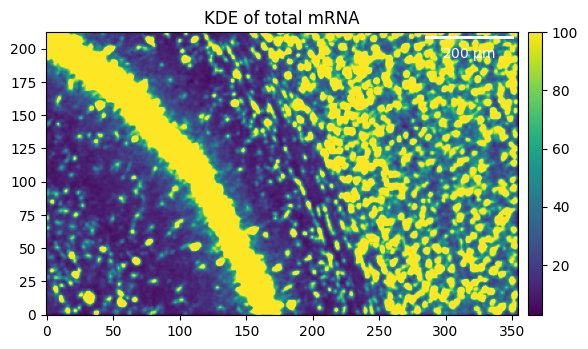

In [32]:
_ = brain.plot_KDE(im_kwargs={"vmax": 100})

Now we can filter the background. Note, that later we can further refine this and define
background filter on the total mRNA KDE per cell type. 

In [33]:
brain.filter_background(0.4)

## Supervised analysis

Assign a cell type to every pixel based on a set of known gene expression signatures

In [34]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 1738 × 5005
    obs: 'region', 'slide', 'cell_id', 'area'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'intensities', 'spatial'

In [36]:
expr = adata.to_df()
expr["cell_type"] = adata.obs["cell_id"]

## Unsupervised analysis

To generate the cell-type map we will need a set of gene expression signatures.
These can either be derived from previous studies e.g. scRNAseq or we can identify them 
*de novo* from the sample we are analysing.

The *de novo* approach works by finding the local maxima of the gene expression and 
treating these as proxies for cells. We can then use standard single-cell/spatial workflows 
to process and cluster the cells. The cell-types indentified in the clustering can then 
be used to calculate the gene expression signatures.

The first step is to identify the local maxiam, we set a minimum distance to avoid 
sampling too many close-by spots.

In [65]:
brain.find_local_maxima(5)
brain

LazyKDE (16 threads)
    genes: 5005
    shape: (355, 213)
    resolution: 3000.0 nm / px
    kernel: (5, 5)
    background: set
    local maxima: 437

### Find cell-type signatures

Next we can load the local maxima into and `AnnData` object and then proceed to identify
clusters.

In [66]:
local_max = brain.load_local_maxima()
local_max

/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 437 × 5005
    obs: 'total_mRNA_KDE'
    obsm: 'spatial'

In [67]:
# for reproducibility
random_state = 42

In [68]:
sc.pp.normalize_total(local_max)

In [69]:
local_max.layers["counts"] = local_max.X.copy()

In [70]:
sc.pp.log1p(local_max)
sc.pp.pca(local_max, random_state=random_state)
sc.pp.neighbors(local_max, random_state=random_state)
sc.tl.umap(local_max, random_state=random_state)

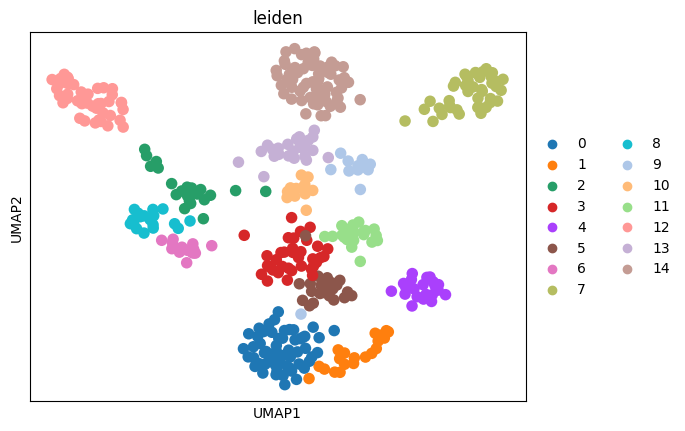

In [71]:
sc.tl.leiden(local_max, resolution=2, flavor="igraph", random_state=random_state)

sc.pl.umap(local_max, color="leiden")

After we have identified our cell-types/clusters we can easily calculate the gene expression
signatures.

Note, the gene expression signatures should be strictly positive i.e. they should not be 
calculated from data that has been standardized or similar.

The following code cell can be ignored (you still need to run it but do not pay to much attention), it is just a currently not yet released improvement to reduce the memory usage when calculating the cell-type signatures.

In [72]:
# please ignore, unreleased improvements for sainsc 

from collections.abc import Hashable

import anndata as ad
import numpy as np
import pandas as pd
from numpy.typing import DTypeLike


def celltype_signatures(
    adata: ad.AnnData,
    *,
    celltype_col: str = "leiden",
    layer: str | None = None,
    dtype: DTypeLike = np.float32,
) -> pd.DataFrame:
    """
    Calculate gene expression signatures per 'cell type'.

    Parameters
    ----------
    adata : anndata.AnnData
    celltype_col : str, optional
        Name of column in :py:attr:`anndata.AnnData.obs` containing cell-type
        information.
    layer : str, optional
        Which :py:attr:`anndata.AnnData.layers` to use for aggregation. If `None`,
        :py:attr:`anndata.AnnData.X` is used.
    dytpe : numpy.typing.DTypeLike
        Data type to use for the signatures.

    Returns
    -------
    pandas.DataFrame
        :py:class:`pandas.DataFrame` of gene expression aggregated per 'cell type'.
    """
    X = adata.X if layer is None else adata.layers[layer]
    grouping = adata.obs.groupby(celltype_col, observed=True, sort=False).indices

    signatures: dict[Hashable, np.ndarray] = {}
    for name, indices in grouping.items():
        mean_X_group = X[indices].mean(axis=0, dtype=dtype)
        signatures[name] = (
            mean_X_group.A1 if isinstance(mean_X_group, np.matrix) else mean_X_group
        )

    return pd.DataFrame(signatures, index=adata.var_names)

In [73]:
signatures = celltype_signatures(local_max, celltype_col="leiden")

### Generate cell-type map

To generate the cell-type map we just need to pass the signature DataFrame to the `assign_celltype` method.

If the gene expression varies across multiple orders of magnitude across genes it might be useful to
use log-transformation after calculating the KDE. In this case the gene expression 
signatures should be calculated from log-transformed data, as well.

In [74]:
brain.assign_celltype(signatures, log=True)

In [75]:
# maintain the same coloring as in UMAP
cmap = {
    cluster: color
    for cluster, color in zip(
        local_max.obs["leiden"].cat.categories, local_max.uns["leiden_colors"]
    )
}

We can now visualize our cell-type map.

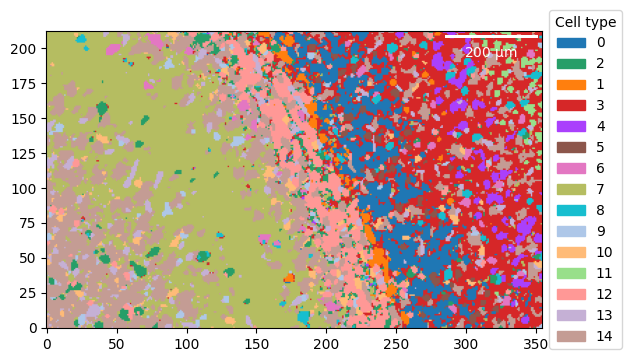

In [76]:
_ = brain.plot_celltype_map(cmap=cmap)

The assignment score can be helpful to identify regions with low confidence in the cell-type
assignment. This is especially useful when using pre-existing cell-type signatures as it 
might highlight regions where we couldn't map any cell-type with high confidence and therefore
might indicate that cell-types are missing in the reference.

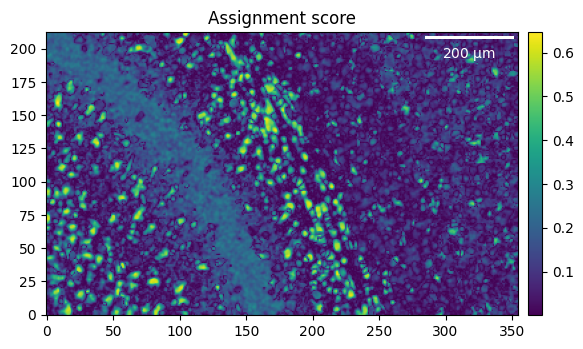

In [77]:
_ = brain.plot_assignment_score(remove_background=True)

In [78]:
kde_per_celltype = pd.DataFrame(
    {
        "kde": brain.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            brain.celltype_map.flatten(), categories=brain.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.5)["kde"] / 2
).to_dict()

min_t = 0.02

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

brain.filter_background(celltype_threshold)

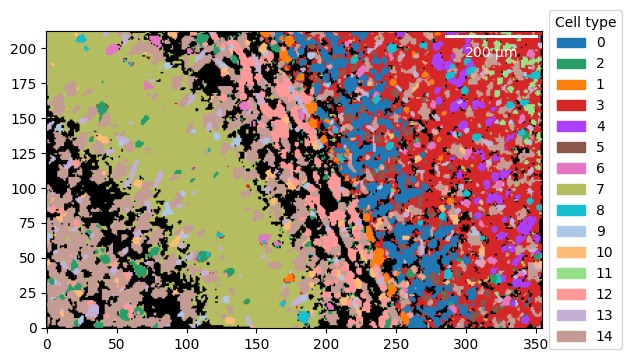

In [79]:
_ = brain.plot_celltype_map(cmap=cmap)

We can zoom-in by defining the ROI that we want to plot. 

ValueError: zero-size array to reduction operation minimum which has no identity

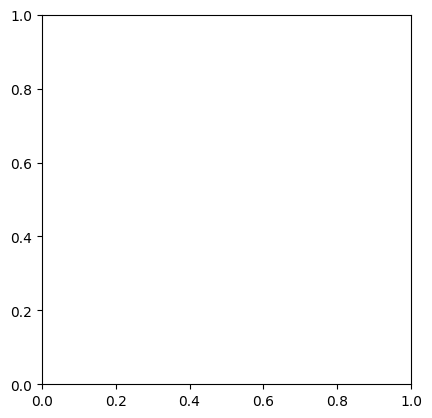

In [80]:
roi = ((1_000, 4_500), (4_000, 6_000))

_ = brain.plot_celltype_map(cmap=cmap, crop=roi, scalebar_kwargs={"box_alpha": 0.7})

We can also highlight only one/few cell-types by removing the rest from the colormap.

ValueError: zero-size array to reduction operation minimum which has no identity

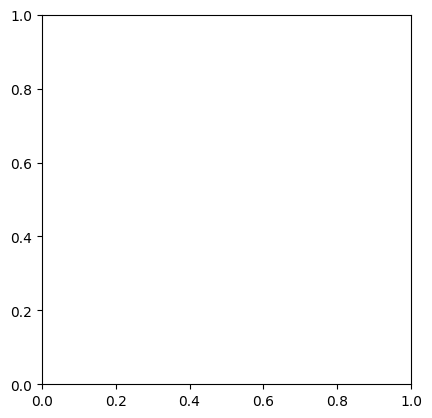

In [81]:
cmap2 = {"0": "yellow"}

_ = brain.plot_celltype_map(cmap=cmap2, crop=roi, scalebar_kwargs={"box_alpha": 0.7})

Visualizing the gene expression can help rationalizing the assigned cell-types.

/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/sainsc/lazykde/_LazyKDE.py:635: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(img.T, origin="lower", **im_kwargs)
/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/sainsc/lazykde/_LazyKDE.py:635: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(img.T, origin="lower", **im_kwargs)


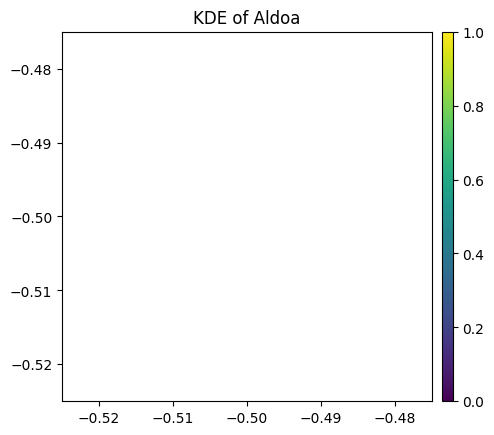

In [82]:
_ = brain.plot_KDE(gene=signatures["0"].idxmax(), crop=roi)

In [83]:
_ = brain.plot_KDE(gene=signatures["18"].idxmax(), crop=roi)

KeyError: '18'

## Bonus task: Supervised analysis

Try using `sainsc` for a supervised analysis leveraging the cell-type signatures obtained from your previous segmentation-based analysis workflow.